In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import wrangle as wr

from env import get_db_url

# <span style='color:red'> Questions: </span>
## - Acquire:
- Is it perhaps a bad idea to include the sale date? Would this leave the realm of regression and move into time series analysis?

## - Wrangle:
- Is it worth splitting all of the functions up in the wrangle.py file?
- Would it be circular logic to include the tax amount, calculate the tax rate, and use that as a predictor of sale price?
    - The tax value is a product of sale price, so it may be useless/even harmful to include tax rate as a *predictor* of sale price. 

# Acquiring Data:
- Acquiring data for *single family homes* that have transaction dates *during the year of 2017.*

In [2]:
query_df = wr.get_zillow_data()

In [3]:
#query_df['bed_bath_ratio'] = df.bedroomcnt / df.bathroomcnt

In [4]:
#Verifying that the dataset meets the rubric requirement of being 52,441 homes long:
query_df.shape[0] / 52441

1.0

In [5]:
query_df[query_df.value != (query_df.land_value + query_df.structure_value)].shape[0]

84

In [6]:
query_df.columns

Index(['bathrooms', 'bedrooms', 'value', 'tax_amount', 'square_feet',
       'year_built', 'fips', 'latitude', 'longitude', 'lot_size', 'zip_code',
       'structure_value', 'land_value', 'sale_date'],
      dtype='object')

In [7]:
query_df.head()

,bathrooms,bedrooms,value,tax_amount,square_feet,year_built,fips,latitude,longitude,lot_size,zip_code,structure_value,land_value,sale_date
0,3.5,4.0,1023282.0,11013.72,3100.0,1998.0,6059.0,33634931.0,-117869207.0,4506.0,96978.0,485713.0,537569.0,2017-01-01
1,1.0,2.0,464000.0,5672.48,1465.0,1967.0,6111.0,34449266.0,-119281531.0,12647.0,97099.0,88000.0,376000.0,2017-01-01
2,2.0,3.0,564778.0,6488.30,1243.0,1962.0,6059.0,33886168.0,-117823170.0,8432.0,97078.0,85289.0,479489.0,2017-01-01
3,3.0,4.0,145143.0,1777.51,2376.0,1970.0,6037.0,34245180.0,-118240722.0,13038.0,96330.0,108918.0,36225.0,2017-01-01
4,3.0,4.0,773303.0,9516.26,2962.0,1950.0,6037.0,34145202.0,-118179824.0,63000.0,96293.0,276684.0,496619.0,2017-01-01


<AxesSubplot:xlabel='latitude', ylabel='longitude'>

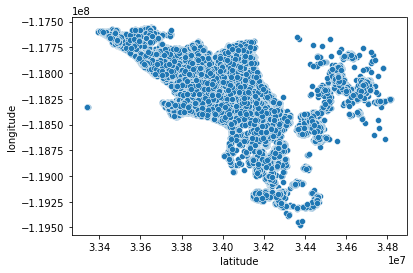

In [8]:
sns.scatterplot(data = query_df, x = query_df.latitude, y = query_df.longitude)

## Wrangling Data:
- General Data Format Cleaning:
    - Converting moving decimal left 6 places on latitude and longitude.
- Assigning county names to each home, based on the fips code one the record:
    - 60370: Los Angeles County
    - 60490: Orange County
    - 61110: Ventura County
- Homes Dropped:
    - 0 bedrooms
    - 0 bathrooms
    - Less than 120 square feet
    - More than 10,000 square feet
    - Home value over \\$1.6 million
    - Records containing null values
- Columns Created:
    - Column displaying the ratios of bedrooms to bathrooms.
- This, paired with the other operations and cleaning carried out in the wrangle script, leave 95.4\% of the data remaining. 
- I feel comfortable with the omission of this data, as I want to ensure that I'm not excluding too large a chunk of my total set, but do want to be sure that I'm focusing my model on homes that comprise the bulk of Zillow's business. Homes priced in the millions are very clearly not the main focus of Zillow's model, so I don't want to skew it's training by including too many of those. See plot below.

In [9]:
#Acquiring CLEANED data, beyond the initial SQL query:
df = wr.wrangle_zillow()

In [10]:
#Verifying how much of the data was cleaned out (less than 5%):
df.shape[0] / query_df.shape[0]

0.9471024580004195

In [11]:
# splitting the data into train, validate, and test sets before exploration:
train, validate, test = wr.split_zillow_data(df)

# Exploring Data:

## Early Hypotheses:
- More square footage will lead to more value.
- Location will have a significant impact on value.
- More bedrooms and more bathrooms will lead to more value.
- There will be a relationship between the bath-to-bed ratio and price.
    - Homes with higher bath-to-bed ratios will fetch higher prices.
- Newer houses will fetch more value.

In [12]:
train.head()

,bathrooms,bedrooms,value,tax_amount,square_feet,year_built,latitude,longitude,lot_size,zip_code,structure_value,land_value,sale_date,county,bath_bed_ratio
18435,2.0,3,380732.0,5150.85,1286.0,1970,33.848519,-118.249615,5113.0,96230.0,153272.0,227460.0,2017-04-18,Los Angeles County,0.666667
10503,4.0,5,525269.0,6564.72,2664.0,1954,34.216195,-118.412888,25222.0,96450.0,238249.0,287020.0,2017-03-09,Los Angeles County,0.800000
45819,4.0,7,135891.0,1742.56,3060.0,1966,33.883593,-117.902149,10560.0,97039.0,100159.0,35732.0,2017-08-17,Orange County,0.571429
24237,2.0,3,322902.0,3416.38,1375.0,1964,34.274476,-119.176572,6550.0,97084.0,193745.0,129157.0,2017-05-12,Ventura County,0.666667
18927,3.0,3,1335745.0,15635.14,1936.0,1937,33.749113,-118.121175,1989.0,96237.0,353725.0,982020.0,2017-04-20,Los Angeles County,1.000000


[Text(0.5, 1.0, 'Distribution of Homes by Price')]

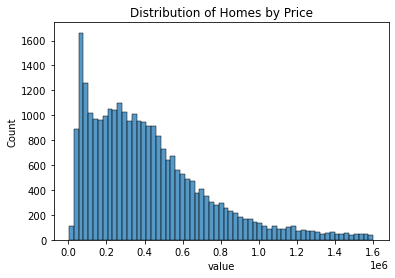

In [13]:
#Visualizing the distribution of homes by price within the train set:
sns.histplot(data = train, x = train.value).set(title = 'Distribution of Homes by Price')